### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Define a problem, describe business context.
2. Load data, preclean it.
3. EDA: target, features.
4. Descibe train/test split strategy. Show main results and discuss them.
5. Run evth for a few periods. Show feature importance and error analysis.

### 1. Business problem

#### Objective:

#### Metric:

#### Summary of results:


### 2. Load data and preclean it

In [26]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option('display.max_columns', 150)
gc.enable()

In [27]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [28]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [29]:
# Functions for Optuna NNs

cv_nn_regularizer = 0.075

def create_snnn4_model_hyperpars(neurons_base=4, l1_reg_rate=0.1, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn4_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)
    l1_reg_rate = trial.suggest_float('l1_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn


def create_snnn6_model_hyperpars(neurons_base=4, l1_reg_rate=0.1, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn6_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)
    l1_reg_rate = trial.suggest_float('l1_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate), 
                              input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg_rate, l2=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn


def objective_nn4(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn4_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=0, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        loss_train = model.evaluate(X_train, y_train, verbose=0)
        loss_val = model.evaluate(X_val_extra, y_val_extra, verbose=0)
        overfit = max(loss_val[1]-loss_train[1], 0)
        return loss_val[1] + cv_nn_regularizer*overfit
    
    
def objective_nn6(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn6_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=0, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        loss_train = model.evaluate(X_train, y_train, verbose=0)
        loss_val = model.evaluate(X_val_extra, y_val_extra, verbose=0)
        overfit = max(loss_val[1]-loss_train[1], 0)
        return loss_val[1] + cv_nn_regularizer*overfit


In [30]:
time0 = time.time()

min_prd = 350
windows_width = 5*12
cv_xgb_regularizer=0.2
optuna_xgb_trials = 80
optuna_nn_trials = 100


with open('../input/mleap-46-preprocessed/MLEAP_46_v7.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+10))]
df_cnt = df.count()
empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
df.drop(columns=empty_cols, inplace=True)
#display(df.shape, df.head(), df.year.describe(), df.count())

features_miss_dummies = ['amhd', 'BAspr']
for col in features_miss_dummies:
    if col in df.columns:
        df[col+'_miss'] = df[col].isnull().astype(int)


### 3. EDA

### 4. Train/test split strategy

#### Main results

In [31]:
results_df = pd.read_csv('../input/mleap-v49-results/temp_models_reg005_1.csv')
results_df

,Unnamed: 0,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,0,100,0.110633,-0.010679,0.005897,0.032282,0.009775,0.016553,0.142414,0.097214,0.017316,0.092751,-0.004731,0.004806,0.077033,0.003310,0.007623,2.368052e-02,-0.006378,4.413288e-03,2.373109e-02,-1.185371e-03,0.006157
1,1,125,0.066434,0.004399,0.015985,0.040227,0.053275,0.020740,0.081517,0.077877,0.018348,0.020937,0.023310,0.014654,0.039157,0.018810,0.009496,-1.010410e-06,-0.000038,-1.945688e-05,-7.328776e-07,-3.910448e-05,-0.000020
2,2,150,0.064235,0.028400,-0.007106,0.108114,0.136225,-0.040268,0.102913,0.141299,-0.040073,0.039123,0.041242,-0.044962,0.046364,0.044968,-0.055987,4.366676e-02,0.040878,-4.501329e-02,5.041909e-02,4.294926e-02,-0.043427
3,3,175,0.073734,0.019790,-0.011655,0.093350,0.065665,0.000453,0.017994,0.013669,-0.002192,0.057370,0.021523,-0.006702,0.064954,0.017231,-0.010337,-4.252701e-06,-0.000010,-4.954723e-07,-7.191610e-09,-6.917556e-07,-0.000008
4,4,200,0.056176,0.048308,0.034120,0.111365,0.141292,0.040536,0.057042,0.089245,0.040346,0.041166,0.071331,0.022324,0.041645,0.073893,0.025533,3.709691e-02,0.065155,2.521314e-02,3.844909e-02,6.439698e-02,0.024244
5,5,225,0.064410,-0.005404,0.012234,0.083176,0.067360,0.026466,0.070134,0.033220,0.020088,0.055780,0.008508,0.012525,0.052652,0.008472,0.013793,-5.871936e-07,-0.000169,-1.014969e-04,-5.182621e-06,-1.285523e-04,-0.000073
6,6,250,0.061997,-0.017393,0.027061,0.018820,-0.001580,0.013451,0.189037,0.155622,0.031786,0.048662,-0.007640,0.024796,0.048832,-0.016709,-0.007211,-1.719546e-09,-0.000007,-2.775066e-06,-8.389908e-07,-2.850800e-06,-0.000007
7,7,275,0.084432,0.128375,0.097800,0.109516,0.192547,0.108320,0.102921,0.176972,0.108397,0.073269,0.144908,0.110993,0.070322,0.143302,0.112889,7.233643e-02,0.144175,1.100276e-01,7.211387e-02,1.423667e-01,0.106699
8,8,300,0.109596,0.041026,0.083551,0.097602,0.058866,0.086605,0.098751,0.054814,0.084547,0.098849,0.040880,0.086885,0.095496,0.042473,0.086713,1.023098e-01,0.039196,8.664547e-02,9.784490e-02,3.844309e-02,0.087651
9,9,325,0.111924,0.042263,-0.038793,0.133787,0.091224,-0.039374,0.112554,0.067039,-0.034580,0.106888,0.049632,-0.052411,0.104488,0.049346,-0.055748,9.684091e-02,0.041965,-6.858033e-02,1.009017e-01,4.594199e-02,-0.066538


### 5. Fit the model(s) for one window and explore results

(146944, 41)

(7507, 41)

(7561, 41)

Number of features before transformation:  (146944, 38)
time to do feature proprocessing: 
Number of features after transformation:  (146944, 86) (7507, 86) (7431, 86) (7561, 86)
mae of a constant model 10.01529988807284
R2 of a constant model 0.0
fixed XGB train: 9.55921006173112 0.06410827554684584
XGB val: 9.271005226317717 0.02066692926133007
XGB val extra: 10.901656205339957 0.01356724415096211
XGB test: 9.4228780692512 0.031484648991487285
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.021518235581785672 78.80262470245361
XGB train: 9.602715421644447 0.055272575410556635
XGB validation: 9.214616030425278 0.03338672541856802
XGB validation extra: 10.826646916675854 0.026527574479032645
XGB test: 9.409131718392727 0.03312134954357382
Total time for hypermarameter optimization, XGB:  279.26213932037354
        n_estimators : 1168
           max_depth : 2
       learning_rate : 0.016939671171658614
    colsample_bytree : 0.5735

'Optuna NN4'

{'neurons_base': 6,
 'l2_regularizer': 0.3597316955065116,
 'l1_regularizer': 0.04172337735181555}

1130.4501633644104

[6, 0.3597316955065116, 0.04172337735181555]

Time for hyperparameter optimization:  1130.4606156349182 [6, 0.3597316955065116, 0.04172337735181555]


'Optuna NN6'

{'neurons_base': 24,
 'l2_regularizer': 0.5811442495468524,
 'l1_regularizer': 0.04799275515347461}

807.0093257427216

[24, 0.5811442495468524, 0.04799275515347461]

Time for hyperparameter optimization:  807.0196619033813 [24, 0.5811442495468524, 0.04799275515347461]
total time for the script:  2493.2662994861603


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,350,0.064108,0.020667,0.031485,0.055273,0.033387,0.033121,0.055539,0.034006,0.033075,0.057466,0.029474,0.022955,0.057071,0.027439,0.02969,0.051402,0.027272,0.023739,0.051426,0.027512,0.029561


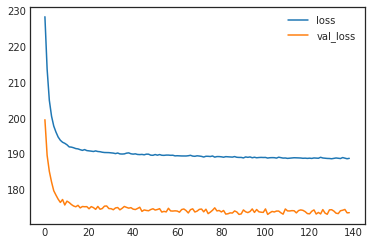

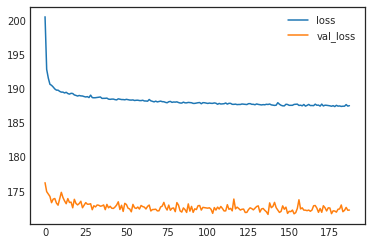

In [32]:
temp_cols = ['PERMNO', 'year', 'prd']
df.reset_index(inplace=True, drop=True)
X = df.copy()
y = X.pop('RET')

train_indx = X.prd<(min_prd+windows_width-1)
val_indx = X['prd'].isin(range(min_prd+windows_width-1, min_prd+windows_width+2))
val_indx_extra = X['prd'].isin(range(min_prd+windows_width+5, min_prd+windows_width+8))
test_indx = X['prd'].isin(range(min_prd+windows_width+2, min_prd+windows_width+5))

X_train = X[train_indx]
X_val = X[val_indx]
X_val_extra = X[val_indx_extra]
X_test = X[test_indx]
y_train = y[train_indx]
y_val = y[val_indx]
y_val_extra = y[val_indx_extra]
y_test = y[test_indx]

#display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
#display(X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())
display(X_train.shape, X_val.shape, X_test.shape)

X_train.drop(columns=temp_cols, inplace=True)
X_val.drop(columns=temp_cols, inplace=True)
X_val_extra.drop(columns=temp_cols, inplace=True)
X_test.drop(columns=temp_cols, inplace=True)

#display(X_train.tail())
col_cat = ['ind']
col_num = [x for x in X_train.columns if x not in col_cat]
for col in col_num:
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_val[col] = X_val[col].fillna(X_train[col].median())
    X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
    X_test[col] = X_test[col].fillna(X_train[col].median())
for col in col_cat:
    X_train[col] = X_train[col].fillna(value=-1000)
    X_val[col] = X_val[col].fillna(value=-1000)
    X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
    X_test[col] = X_test[col].fillna(value=-1000)

#display(X_train.tail())
feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                        ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                        remainder="passthrough")

print('Number of features before transformation: ', X_train.shape)
train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ')
print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
X_train.index = train_index
X_val.index = val_index
X_val_extra.index = val_index_extra
X_test.index = test_index
#display(X_train.tail())

X = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val])
#display(X,y)

X_ = pd.concat([X_train, X_val, X_val_extra])
y_ = pd.concat([y_train, y_val, y_val_extra])
#display(X,y, X_,y_)


results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test',
                                  'nn4_train', 'nn4_val', 'nn4_test',
                                 'nn6_train', 'nn6_val', 'nn6_test',
                                 'nn4opt_train', 'nn4opt_val', 'nn4opt_test',
                                 'nn6opt_train', 'nn6opt_val', 'nn6opt_test'])

results['min_prd'] = [min_prd]


### Modeling part ###

print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
xgb1.fit(X_train, y_train)
print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
[r2_score(y_train, xgb1.predict(X_train)), 
r2_score(y_val, xgb1.predict(X_val)),
r2_score(y_test, xgb1.predict(X_test))]

time1 = time.time()

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_train.index else 0 for x in X.index]
pds = PredefinedSplit(test_fold = split_index)

xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
              'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

# Fit with all data
xgbgs.fit(X_, y_)

print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
[r2_score(y_train, xgbgs.predict(X_train)), 
r2_score(y_val, xgbgs.predict(X_val)),
r2_score(y_test, xgbgs.predict(X_test))]

time1 = time.time()
def objective_xgb(trial, cv_runs=1, n_splits=2, n_jobs=-1):

    params = {
    "tree_method": 'gpu_hist',
    "verbosity": 0,  # 0 (silent) - 3 (debug)
    "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
    "max_depth": trial.suggest_int("max_depth", 2, 6),
    "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
    "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
    "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
    "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
    "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
    "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
    "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

    model = XGBRegressor(**params, njobs=-1)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

    score_train = r2_score(y_train, model.predict(X_train))
    score_val = r2_score(y_val, model.predict(X_val))
    score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
    score_val = (score_val+score_val_extra)/2
    overfit = np.abs(score_train-score_val)

    return score_val-cv_xgb_regularizer*overfit


study = optuna.create_study(direction="maximize")
study.optimize(objective_xgb, n_trials=optuna_xgb_trials)
print('Total time for hypermarameter optimization, XGB: ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")
optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_xgb = XGBRegressor(**optuna_hyperpars)
optuna_xgb.fit(X, y)
print('Optuna XGB train: \n', 
      mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
      mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
      mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
      mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
[r2_score(y_train, optuna_xgb.predict(X_train)), 
r2_score(y_val, optuna_xgb.predict(X_val)),
r2_score(y_test, optuna_xgb.predict(X_test))]

###########
### NNs ###
###########

neurons_base = 8
l2_reg_rate = 0.5

model_snn6 = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn6.count_params())

early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
optimizer_adam = tf.keras.optimizers.Adam()

model_snn6.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

time1 = time.time()
history = model_snn6.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

results.loc[results.min_prd==min_prd,'nn6_train':'nn6_test'] = \
[r2_score(y_train, model_snn6.predict(X_train)), 
r2_score(y_val, model_snn6.predict(X_val)),
r2_score(y_test, model_snn6.predict(X_test))]



neurons_base = 8
l2_reg_rate = 0.3

model_snn4 = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn4.count_params())

time1 = time.time()
model_snn4.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_snn4.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

results.loc[results.min_prd==min_prd,'nn4_train':'nn4_test'] = \
[r2_score(y_train, model_snn4.predict(X_train)), 
r2_score(y_val, model_snn4.predict(X_val)),
r2_score(y_test, model_snn4.predict(X_test))]



# try optuna, using this kaggle notebook: https://www.kaggle.com/code/mistag/keras-model-tuning-with-optuna

time1 = time.time()
study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective_nn4, n_trials=optuna_nn_trials)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
temp = study.best_params
display('Optuna NN4', study.best_params, time.time()-time1)

optimal_hyperpars = list(temp.values())
display(optimal_hyperpars)
print('Time for hyperparameter optimization: ',time.time()-time1, optimal_hyperpars)

optuna_nn = create_snnn4_model_hyperpars(neurons_base=optimal_hyperpars[0], 
                                         l2_reg_rate=optimal_hyperpars[1],
                                        l1_reg_rate=optimal_hyperpars[2])
history = optuna_nn.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        batch_size=2048, 
                        epochs=1000,
                        verbose=0, 
                        callbacks=[early_stopping50])

results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
[r2_score(y_train, optuna_nn.predict(X_train)), 
r2_score(y_val, optuna_nn.predict(X_val)),
r2_score(y_test, optuna_nn.predict(X_test))]


time1 = time.time()
study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective_nn6, n_trials=optuna_nn_trials)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
temp = study.best_params
display('Optuna NN6', study.best_params, time.time()-time1)

optimal_hyperpars = list(temp.values())
display(optimal_hyperpars)
print('Time for hyperparameter optimization: ', time.time()-time1, optimal_hyperpars)

optuna_nn = create_snnn6_model_hyperpars(neurons_base=optimal_hyperpars[0], 
                                         l2_reg_rate=optimal_hyperpars[1],
                                        l1_reg_rate=optimal_hyperpars[2])
history = optuna_nn.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        batch_size=2048, 
                        epochs=1000,
                        verbose=0, 
                        callbacks=[early_stopping50])

results.loc[results.min_prd==min_prd,'nn6opt_train':'nn6opt_test'] = \
[r2_score(y_train, optuna_nn.predict(X_train)), 
r2_score(y_val, optuna_nn.predict(X_val)),
r2_score(y_test, optuna_nn.predict(X_test))]


print('total time for the script: ', time.time()-time0)
display(results)

In [97]:
### Feature Importance

explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance_xgb = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col','feature_importance_vals'])

#select backgroud for shap
background = X_train.sample(1000)
explainernn = shap.DeepExplainer(optuna_nn, background.to_numpy())
shap_values_XGBoost_test = explainernn.shap_values(X_test.to_numpy())
vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance_nn = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col','feature_importance_vals'])
feature_importance_xgb.sort_values('feature_importance_vals', inplace=True, ascending=False)
#feature_importance_nn.sort_values('feature_importance_vals', inplace=True, ascending=False)
display(feature_importance_xgb[:20])
display(feature_importance_nn[:20])

StagingError: in user code:

    /opt/conda/lib/python3.7/site-packages/shap/explainers/_deep/deep_tf.py:252 grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/backprop.py:1090 gradient  **
        unconnected_gradients=unconnected_gradients)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/imperative_grad.py:77 imperative_grad
        compat.as_str(unconnected_gradients.value))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/backprop.py:148 _gradient_function
        grad_fn = ops._gradient_registry.lookup(op_name)  # pylint: disable=protected-access
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/registry.py:100 lookup
        "%s registry has no entry for: %s" % (self._name, name))

    LookupError: gradient registry has no entry for: shap_Selu


In [94]:
X_train.to_numpy()

array([[-0.22899244, -1.26739458,  0.99594085, ...,  0.        ,
         0.        ,  0.        ],
       [-0.22899244, -1.19330221,  0.99594085, ...,  0.        ,
         0.        ,  0.        ],
       [-0.22899244, -1.04223701,  0.99594085, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.67822648, -0.65380383,  2.04005009, ...,  0.        ,
         0.        ,  0.        ],
       [-0.84250641, -0.72387035,  2.04005009, ...,  0.        ,
         0.        ,  0.        ],
       [-0.8777894 , -0.61384683,  2.04005009, ...,  0.        ,
         0.        ,  0.        ]])

In [62]:
mask = np.random.choice(X_train.shape[0], 1000, replace=False)
display(mask[:10])
display(X_train.iloc[mask])

array([ 80305, 132682,  37876, 140044, 145230,  72815, 127923, 102834,
        22572,  29595])

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
95807,-0.228992,-0.756919,-0.200420,0.114034,0.756480,0.238103,-0.565231,-0.867306,1.111877,0.351920,0.455054,-0.148357,-0.039135,0.294719,0.313914,0.163729,-0.267890,-0.832382,0.447861,0.705072,1.255524,-0.076198,1.109299,-0.123594,1.129819,-0.071221,1.094246,1.143549,0.910151,-0.123594,-0.691005,0.435577,0.622072,-0.775770,0.575428,0.220169,-0.601648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156852,-0.228992,1.284559,-0.322588,0.948252,1.590109,0.341196,-0.152824,0.083959,0.180234,-0.383518,-0.425115,1.448207,0.196649,-0.142946,-0.127285,-0.300076,0.126807,-0.120326,0.805255,1.268385,0.228336,0.065931,0.163304,0.011411,0.135292,0.269357,0.081083,-0.719619,0.187095,0.011411,0.757908,-0.446815,-0.414910,-0.408160,-0.452746,-0.522885,-0.601648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
46959,0.028741,1.043630,-0.213631,-0.640662,-1.627888,-1.290158,-0.135237,0.111836,-1.373298,-0.555718,-0.743468,1.440116,-0.240818,-0.572395,-0.759291,-0.046502,1.532725,0.704911,-0.800893,-1.687934,-0.856356,1.548613,-1.376233,-0.212044,-1.378667,-0.418266,-1.363694,0.305160,-1.450352,-0.212044,1.105346,-0.574079,-0.546443,0.981479,-0.619706,-0.637568,-0.601648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166149,-1.110850,-0.995191,-2.394788,-0.338292,1.974639,2.822136,-0.029552,-0.998243,0.087111,-1.151687,-1.148836,-1.843661,-1.068713,-1.155422,-1.244777,-0.276910,-0.635467,-1.895231,-2.509324,0.439276,-0.992112,-1.160041,0.088152,-1.071380,0.091095,-1.074540,0.093311,-1.073193,0.096262,-1.071380,-0.452831,-1.156285,-1.153815,-1.546371,-1.244234,-0.846934,1.662103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
172362,-0.609519,-0.772264,0.243621,0.000432,0.190587,-0.143319,-0.034497,-0.268698,0.087111,-1.103148,-1.122254,-0.775736,-0.852199,-1.155422,-0.416780,-0.396230,-1.324036,0.813551,-0.268984,-0.024723,-0.334367,-1.358829,0.088152,0.866867,0.091095,-0.387505,0.093311,-0.244493,0.096262,0.866867,0.033318,2.549540,1.418287,-0.512380,0.417254,0.040040,1.662103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [71]:
random.sample([1,3,5,6],2)

[3, 6]

In [76]:
X_train[random.sample(list(X_train.index), 10)]

KeyError: "None of [Int64Index([32650, 170056, 68280, 65943, 7428, 71796, 96881, 29774, 123174,\n            164219],\n           dtype='int64')] are in the [columns]"

In [77]:
random.sample(list(X_train.index), 10)

[33028, 45842, 90664, 163606, 60404, 128616, 2148, 90999, 161860, 127684]

In [34]:
### Error Analysis

In [45]:
results

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,350,0.064108,0.020667,0.031485,0.055273,0.033387,0.033121,0.055539,0.034006,0.033075,0.057466,0.029474,0.022955,0.057071,0.027439,0.02969,0.051402,0.027272,0.023739,0.051426,0.027512,0.029561


In [38]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [39]:
print('total time for the script: ', time.time()-time0)
display(results)

total time for the script:  2493.541243314743


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,350,0.064108,0.020667,0.031485,0.055273,0.033387,0.033121,0.055539,0.034006,0.033075,0.057466,0.029474,0.022955,0.057071,0.027439,0.02969,0.051402,0.027272,0.023739,0.051426,0.027512,0.029561


In [40]:
 
# def objective_nn(trial):
    
#     tf.keras.backend.clear_session()
    
#     with strategy.scope():
#         # Generate our trial model.
#         model = create_snnn_model(trial)

#         callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=40),
#         TFKerasPruningCallback(trial, "val_loss"),
#     ]

#         # Fit the model on the training data.
#         # The TFKerasPruningCallback checks for pruning condition every epoch.
        
#         history = model.fit(X_train, y_train, 
#                                 validation_data=(X_val, y_val),
#                                 batch_size=2048, 
#                                 epochs=500, 
#                                 verbose=1, 
#                                 callbacks=callbacks)

#         # Evaluate the model accuracy on the validation set.
#         score = model.evaluate(X_val, y_val, verbose=0)
#         return score[1]

# trials = 50

# study = optuna.create_study(direction="minimize", 
#                             sampler=optuna.samplers.TPESampler(), 
#                             pruner=optuna.pruners.HyperbandPruner())
# study.optimize(objective_nn, n_trials=trials)
# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
# temp = study.best_params
# display(study.best_params, time.time()-time1)

# optimal_hyperpars = list(temp.values())
# display(optimal_hyperpars)
# print(time.time()-time1, optimal_hyperpars)

# optuna_nn = create_snnn_model_hyperpars(neurons_base=optimal_hyperpars[0], l2_reg_rate=optimal_hyperpars[1])
# history = optuna_nn.fit(X_train, y_train, 
#                         validation_data=(X_val, y_val),
#                         batch_size=2048, 
#                         epochs=1000,
#                         verbose=1, 
#                         callbacks=[early_stopping50])

# results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
# [r2_score(y_train, optuna_nn.predict(X_train)), 
# r2_score(y_val, optuna_nn.predict(X_val)),
# r2_score(y_test, optuna_nn.predict(X_test))]

In [41]:
# # try optuna for NN:

# def objective(trial):

#     n_layers = trial.suggest_int('n_layers', 1, 3)
#     model = tf.keras.Sequential()
#     for i in range(n_layers):
#         num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
#         model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
#     model.add(tf.keras.layers.Dense(1))
#     display(model.summary())
#     return accuracy

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)


In [42]:
# on nns:
# - try classic regularizers (l1, l2 etc)
# - try different architecture (not snnn)
# classic architecture:
# He initialization, elu activation, batch norm, l2 reg, adam.

# - try exotic architecture, e.g., wide'n'deep
# 


In [43]:
# usually self-norm seems better: it overfits less and runs faster

